In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.hparams_S5G import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Thu Mar 18 13:20:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 59%   48C    P0    34W / 370W |      0MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 62%   

In [10]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v3"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/scpark/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done
done


In [3]:
save_dir = 'save/model_S5G'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json    save_389704  save_396617  save_410000  save_421814
save_387320  save_390000  save_400000  save_415000
save_388173  save_395000  save_405000  save_420000


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 421814

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 283.0MiB
TTS size 195.3MiB
MelEncoder size 65.3MiB
MelDecoder size 119.0MiB
loaded : 421814
421814
done


In [6]:
trainset = LJDataset(tts_hparams, split='train')
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.021975159645080566


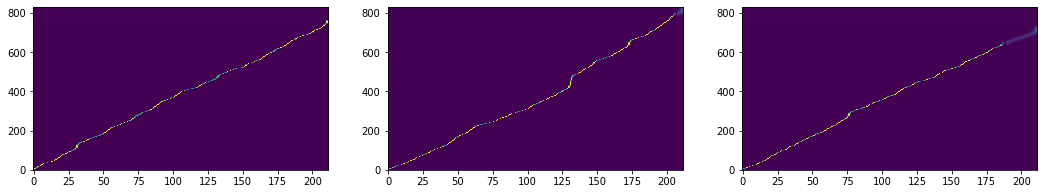

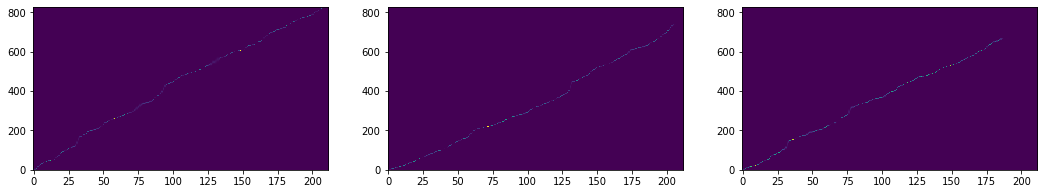

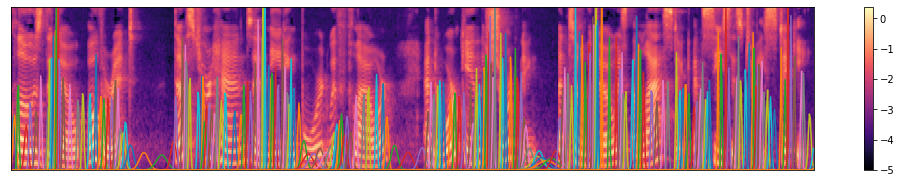

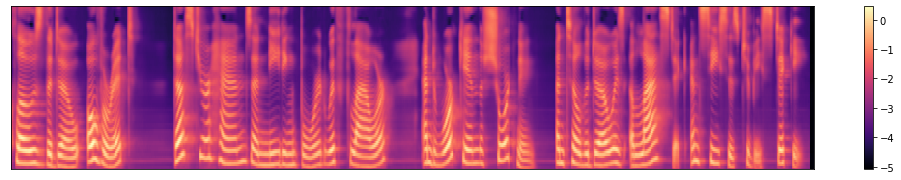

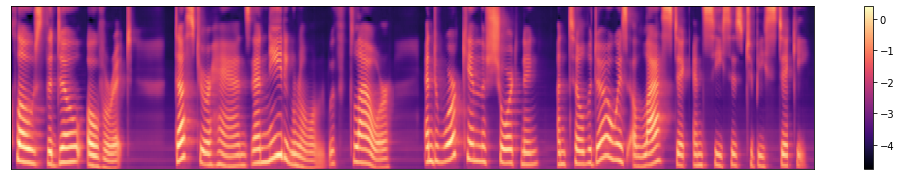

tensor(0.1250, device='cuda:0')
step : 449001 stt : 0.0007 tts : 0.1320 recon : 0.0247 kl : 0.0065 beta : 1.0000
tensor(0.1180, device='cuda:0')
step : 449002 stt : 0.0006 tts : 0.1304 recon : 0.0219 kl : 0.0059 beta : 1.0000
tensor(0.1214, device='cuda:0')
step : 449003 stt : 0.0007 tts : 0.1211 recon : 0.0232 kl : 0.0062 beta : 1.0000
tensor(0.1104, device='cuda:0')
step : 449004 stt : 0.0005 tts : 0.1319 recon : 0.0236 kl : 0.0062 beta : 1.0000
tensor(0.1092, device='cuda:0')
step : 449005 stt : 0.0003 tts : 0.1353 recon : 0.0253 kl : 0.0065 beta : 1.0000
tensor(0.1361, device='cuda:0')
step : 449006 stt : 0.0006 tts : 0.1428 recon : 0.0227 kl : 0.0061 beta : 1.0000
tensor(0.1186, device='cuda:0')
step : 449007 stt : 0.0004 tts : 0.1246 recon : 0.0209 kl : 0.0056 beta : 1.0000
tensor(0.1190, device='cuda:0')
step : 449008 stt : 0.0008 tts : 0.1392 recon : 0.0239 kl : 0.0064 beta : 1.0000
tensor(0.1229, device='cuda:0')
step : 449009 stt : 0.0005 tts : 0.1227 recon : 0.0219 kl : 0.00

tensor(0.1355, device='cuda:0')
step : 449074 stt : 0.0002 tts : 0.1307 recon : 0.0232 kl : 0.0061 beta : 1.0000
tensor(0.1102, device='cuda:0')
step : 449075 stt : 0.0004 tts : 0.1407 recon : 0.0245 kl : 0.0064 beta : 1.0000
tensor(0.1477, device='cuda:0')
step : 449076 stt : 0.0004 tts : 0.1356 recon : 0.0238 kl : 0.0063 beta : 1.0000
tensor(0.1196, device='cuda:0')
step : 449077 stt : 0.0004 tts : 0.1368 recon : 0.0256 kl : 0.0067 beta : 1.0000
tensor(0.1267, device='cuda:0')
step : 449078 stt : 0.0005 tts : 0.1357 recon : 0.0244 kl : 0.0065 beta : 1.0000
tensor(0.1135, device='cuda:0')
step : 449079 stt : 0.0005 tts : 0.1264 recon : 0.0218 kl : 0.0058 beta : 1.0000
tensor(0.1115, device='cuda:0')
step : 449080 stt : 0.0005 tts : 0.1247 recon : 0.0215 kl : 0.0058 beta : 1.0000
tensor(0.1629, device='cuda:0')
step : 449081 stt : 0.0016 tts : 0.1338 recon : 0.0221 kl : 0.0058 beta : 1.0000
tensor(0.1472, device='cuda:0')
step : 449082 stt : 0.0003 tts : 0.1340 recon : 0.0249 kl : 0.00

tensor(0.1345, device='cuda:0')
step : 449147 stt : 0.0005 tts : 0.1311 recon : 0.0242 kl : 0.0063 beta : 1.0000
tensor(0.1517, device='cuda:0')
step : 449148 stt : 0.0004 tts : 0.1382 recon : 0.0265 kl : 0.0068 beta : 1.0000
tensor(0.1151, device='cuda:0')
step : 449149 stt : 0.0004 tts : 0.1384 recon : 0.0244 kl : 0.0065 beta : 1.0000
tensor(0.1088, device='cuda:0')
step : 449150 stt : 0.0001 tts : 0.1264 recon : 0.0227 kl : 0.0061 beta : 1.0000
tensor(0.1559, device='cuda:0')
step : 449151 stt : 0.0004 tts : 0.1366 recon : 0.0245 kl : 0.0065 beta : 1.0000
tensor(0.1215, device='cuda:0')
step : 449152 stt : 0.0005 tts : 0.1348 recon : 0.0241 kl : 0.0063 beta : 1.0000
tensor(0.1232, device='cuda:0')
step : 449153 stt : 0.0005 tts : 0.1300 recon : 0.0251 kl : 0.0065 beta : 1.0000
tensor(0.1055, device='cuda:0')
step : 449154 stt : 0.0004 tts : 0.1288 recon : 0.0218 kl : 0.0059 beta : 1.0000
tensor(0.3079, device='cuda:0')
step : 449155 stt : 0.0008 tts : 0.1351 recon : 0.0236 kl : 0.00

tensor(0.1259, device='cuda:0')
step : 449220 stt : 0.0009 tts : 0.1243 recon : 0.0235 kl : 0.0062 beta : 1.0000
tensor(0.1666, device='cuda:0')
step : 449221 stt : 0.0009 tts : 0.1291 recon : 0.0248 kl : 0.0064 beta : 1.0000
tensor(0.1614, device='cuda:0')
step : 449222 stt : 0.0003 tts : 0.1201 recon : 0.0236 kl : 0.0061 beta : 1.0000
tensor(0.2134, device='cuda:0')
step : 449223 stt : 0.0012 tts : 0.2259 recon : 0.0248 kl : 0.0066 beta : 1.0000
tensor(0.1039, device='cuda:0')
step : 449224 stt : 0.0012 tts : 0.1274 recon : 0.0226 kl : 0.0061 beta : 1.0000
tensor(0.1069, device='cuda:0')
step : 449225 stt : 0.0005 tts : 0.1292 recon : 0.0241 kl : 0.0063 beta : 1.0000
tensor(0.1517, device='cuda:0')
step : 449226 stt : 0.0012 tts : 0.1194 recon : 0.0221 kl : 0.0059 beta : 1.0000
tensor(0.1171, device='cuda:0')
step : 449227 stt : 0.0003 tts : 0.1246 recon : 0.0220 kl : 0.0058 beta : 1.0000
tensor(0.0985, device='cuda:0')
step : 449228 stt : 0.0003 tts : 0.1190 recon : 0.0222 kl : 0.00

tensor(0.1274, device='cuda:0')
step : 449293 stt : 0.0005 tts : 0.1299 recon : 0.0234 kl : 0.0061 beta : 1.0000
tensor(0.1282, device='cuda:0')
step : 449294 stt : 0.0004 tts : 0.1229 recon : 0.0252 kl : 0.0065 beta : 1.0000
tensor(0.1088, device='cuda:0')
step : 449295 stt : 0.0007 tts : 0.1239 recon : 0.0217 kl : 0.0058 beta : 1.0000
tensor(0.1268, device='cuda:0')
step : 449296 stt : 0.0012 tts : 0.1236 recon : 0.0213 kl : 0.0057 beta : 1.0000
tensor(0.1072, device='cuda:0')
step : 449297 stt : 0.0003 tts : 0.1176 recon : 0.0212 kl : 0.0056 beta : 1.0000
tensor(0.2333, device='cuda:0')
step : 449298 stt : 0.0009 tts : 0.2147 recon : 0.0224 kl : 0.0059 beta : 1.0000
tensor(0.1141, device='cuda:0')
step : 449299 stt : 0.0004 tts : 0.1324 recon : 0.0208 kl : 0.0056 beta : 1.0000
tensor(0.0965, device='cuda:0')
step : 449300 stt : 0.0002 tts : 0.1258 recon : 0.0241 kl : 0.0062 beta : 1.0000
tensor(0.0908, device='cuda:0')
step : 449301 stt : 0.0002 tts : 0.1236 recon : 0.0227 kl : 0.00

tensor(0.1031, device='cuda:0')
step : 449366 stt : 0.0008 tts : 0.1393 recon : 0.0253 kl : 0.0066 beta : 1.0000
tensor(0.1216, device='cuda:0')
step : 449367 stt : 0.0005 tts : 0.1346 recon : 0.0263 kl : 0.0068 beta : 1.0000
tensor(0.1160, device='cuda:0')
step : 449368 stt : 0.0002 tts : 0.1230 recon : 0.0234 kl : 0.0062 beta : 1.0000
tensor(0.1002, device='cuda:0')
step : 449369 stt : 0.0005 tts : 0.1244 recon : 0.0223 kl : 0.0060 beta : 1.0000
tensor(0.0971, device='cuda:0')
step : 449370 stt : 0.0004 tts : 0.1383 recon : 0.0246 kl : 0.0065 beta : 1.0000
tensor(0.1425, device='cuda:0')
step : 449371 stt : 0.0008 tts : 0.1350 recon : 0.0232 kl : 0.0062 beta : 1.0000
tensor(0.1409, device='cuda:0')
step : 449372 stt : 0.0001 tts : 0.1242 recon : 0.0241 kl : 0.0063 beta : 1.0000
tensor(0.1087, device='cuda:0')
step : 449373 stt : 0.0003 tts : 0.1226 recon : 0.0222 kl : 0.0060 beta : 1.0000
tensor(0.1191, device='cuda:0')
step : 449374 stt : 0.0008 tts : 0.1148 recon : 0.0217 kl : 0.00

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 500 == 0:
            display.clear_output()
            
            index = 0
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            try:
                _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
                batch_size = _tts_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
                batch_size = _stt_alignments.shape[0]
                plt.figure(figsize=[18, 3])
                for i in range(3):
                    plt.subplot(1, 3, i+1)
                    plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
                plt.show()

                plt.figure(figsize=[18, 3])
                _x = batch['mels'].data.cpu().numpy()
                librosa.display.specshow(_x[index])
                plt.colorbar()

                for i in range(_stt_alignments.shape[1]):
                    plt.plot(_stt_alignments[index, i] * 100)

                plt.show()

                plt.figure(figsize=[18, 3])
                _y = tts_outputs['pred'].data.cpu().numpy()
                librosa.display.specshow(_y[index])
                plt.colorbar()
                plt.show()

                plt.figure(figsize=[18, 3])
                _s = samples.data.cpu().numpy()
                librosa.display.specshow(_s[index, :, :_y.shape[2]])
                plt.colorbar()
                plt.show()
            except:
                pass
                      
        step += 1
        

In [ ]:
logger.save(step, model, optimizer)

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 28:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [59]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(103168,)


0.01645803451538086


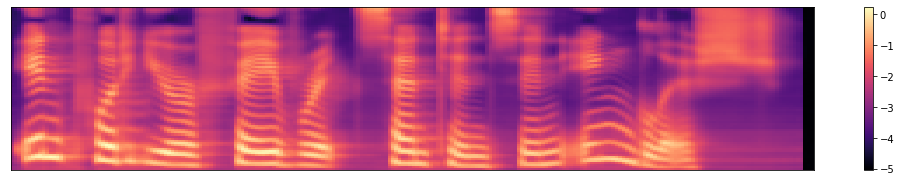

(58880,)


In [60]:
from g2p_en import G2p

g2p = G2p()

t0 = time.time()
text = "Input your favorite sentence in English."
text_array = g2p(text)
text = ""
for t in text_array:
    text += t

text_utf = text.encode()
ts = [0]
for t in text_utf:
    ts.append(t)
ts.append(0)    
utf8_values = np.array(ts)
t = torch.from_numpy(utf8_values).cuda().unsqueeze(0)
model.eval()
with torch.no_grad():
    
    samples, time_dict = model.inference(t, None, None, temperature=1.0)
    _s = samples.data.cpu().numpy()
    t1 = time.time()
    print(t1 - t0)
    plt.figure(figsize=[18, 3])
    librosa.display.specshow(_s[0])
    plt.colorbar()
    plt.show()

vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)